## Week 9: #D Genome
### Radhika Jangi 12/3/2020

### Loading in Data

hifive fends -L genome/mm9.len --binned 100 gen_part.fend

hifive hic-data gen_part.fend -X data/WT_100kb/raw_\*.mat interaction_reads.txt

hifive hic-project -f 25 -n 25 -j 100000 -q interaction_reads.txt hic_project.txt

hifive hic-normalize express -f 25 -w cis hic_project.txt



### Working with HiC Data

In [1]:
import hifive
import matplotlib.pyplot as plt
import numpy as np
import pyBigWig

In [2]:
hic = hifive.HiC('hic_project.txt', 'r')
hic

In [3]:
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)

Finding fend full array for chr13:1000000-120250001... Done


invalid value encountered in divide
divide by zero encountered in log2


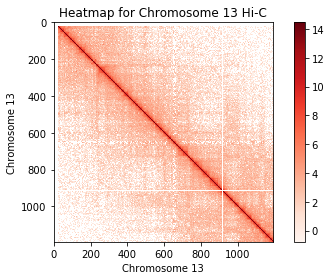

In [4]:
enrichment = np.where(data[:, :, 0]/data[:, :, 1]!= np.nan,data[:, :, 0]/data[:, :, 1],0)
enrich_log = np.log2(enrichment)

fig, ax = plt.subplots()
im = ax.imshow(enrich_log, cmap = 'Reds')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title('Heatmap for Chromosome 13 Hi-C')
ax.set_xlabel('Chromosome 13')
ax.set_ylabel('Chromosome 13')
fig.tight_layout()
plt.show()

### Compartment Analysis

In [5]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Casting complex values to real discards the imaginary part


In [6]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

Casting complex values to real discards the imaginary part


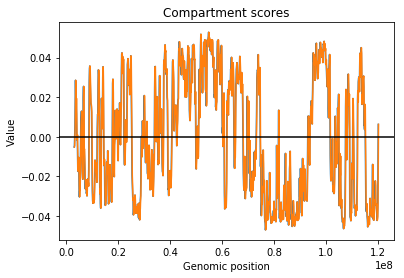

In [7]:
fig, ax = plt.subplots()
ax.plot(X,Y)
ax.set_title('Compartment scores')
ax.set_xlabel('Genomic position')
ax.set_ylabel('Value')
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

grep -v "-" hic_comp.bed > positive_hic_comp.bed

grep "-" hic_comp.bed > negative_hic_comp.bed

bedtools intersect -a data/WT_fpkm.bed -b positive_hic_comp.bed -f 0.5 -wa > pos_overlap.bed

bedtools intersect -a data/WT_fpkm.bed -b negative_hic_comp.bed -f 0.5 -wa > neg_overlap.bed

In [8]:
f = open('pos_overlap.bed','r')
fs = open('neg_overlap.bed','r')
pos_overlap = f.readlines()
neg_overlap = fs.readlines()
f.close()
fs.close()

In [9]:
pos_exp = []
neg_exp = []
for line in pos_overlap:
    line = line.split()
    pos_exp.append(float(line[-1]))
for line in neg_overlap:
    line = line.split()
    neg_exp.append(float(line[-1]))

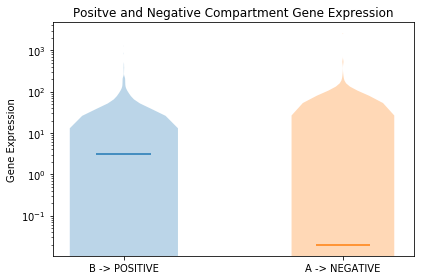

In [10]:
fig, ax = plt.subplots()
ax.violinplot(pos_exp, positions=[0], showmeans=False, showmedians=True, showextrema=False)
ax.violinplot(neg_exp, positions=[1], showmeans=False, showmedians=True, showextrema=False)
ax.set_yscale("log")
ax.set_xticks([0, 1])
ax.set_xticklabels(['B -> POSITIVE', 'A -> NEGATIVE'])
ax.set_ylabel('Gene Expression')
ax.set_title('Positve and Negative Compartment Gene Expression')
fig.tight_layout()
plt.show()

### Expression vs. Repression

In [11]:
def exp_rep(overlap_file):
    '''Gets bw value for each gene based on its coordinates
    INPUT: overlap_file: overlap file for positive or negative comp values
    OUTPUT: bw_final: list of bw values for each gene '''
    
    # Gets bw value for each gene based on its coordinates
    bw = pyBigWig.open('data/WT_H3K27me3.bw')
    bw_list = []
    for gene in overlap_file:
        line = gene.split()
        coord1 = int(line[1])
        coord2 = int(line[2])
        bw_list.append(bw.stats('chr13', coord1, coord2, type='sum'))
    
    # Flattens bw list
    bw_final = []
    for sublist in bw_list:
        for item in sublist:
            bw_final.append(item) 
    
    # Replaces None with 0 in bw flattened list        
    [0 if x is None else x for x in bw_final]
    
    return bw_final

In [12]:
# Create bw lists for 
pos_bw = exp_rep(pos_overlap)
neg_bw = exp_rep(neg_overlap)

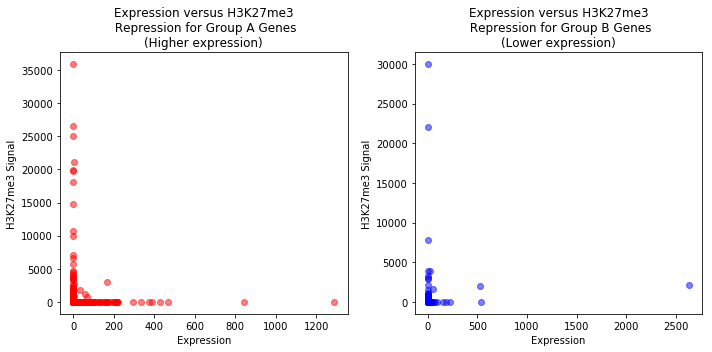

In [13]:
# Plot expression versus repression for A and B
# From the violin plots, the positive compartment genes seem to have higher expression
# so they will represent group A, while negative comapartment will be group B
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
ax[0].scatter(pos_exp,pos_bw,color = 'red',alpha = 0.5)
ax[1].scatter(neg_exp,neg_bw,color = 'blue',alpha = 0.5)
ax[0].set_title('Expression versus H3K27me3\n Repression for Group A Genes\n(Higher expression)')
ax[1].set_title('Expression versus H3K27me3\n Repression for Group B Genes\n(Lower expression)')
ax[0].set_xlabel('Expression')
ax[0].set_ylabel('H3K27me3 Signal')
ax[1].set_xlabel('Expression')
ax[1].set_ylabel('H3K27me3 Signal')
plt.tight_layout()
plt.show()

The higher expression you see, the less methylation is seen: the further along the x axis you go, the less non-zero methylation scores are associated with it

In [14]:
# pos_bw = []
# neg_bw = []
# bw = pyBigWig.open('data/WT_H3K27me3.bw')
# for gene in pos_overlap:
#     line = gene.split()
#     coord1 = int(line[1])
#     coord2 = int(line[2])
#     pos_bw.append(bw.stats('chr13', coord1, coord2, type='sum'))
# for gene in neg_overlap:
#     line = gene.split()
#     coord1 = int(line[1])
#     coord2 = int(line[2])
#     neg_bw.append(bw.stats('chr13', coord1, coord2, type='sum'))

# pos_bw_flat = []
# neg_bw_flat = []
# for sublist in pos_bw:
#     for item in sublist:
#         pos_bw_flat.append(item)

# for sublist in neg_bw:
#     for item in sublist:
#         neg_bw_flat.append(item)

# [0 if x is None else x for x in pos_bw_flat]
# [0 if x is None else x for x in neg_bw_flat]